In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Dropout,BatchNormalization,Layer,GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline
import time

In [ ]:
#Colocar coisa da microsoft

In [2]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        positiveDist = K.sum(K.square(anchor-positive), axis=-1)
        negativeDist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(positiveDist - negativeDist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [3]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',input_shape=input_shape,kernel_initializer='he_uniform',kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',kernel_regularizer=l2(2e-4)))
    network.add(GlobalAveragePooling2D())
    network.add(Dense(4096, activation='relu',kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

In [4]:
def build_model(inputShape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchorInput = Input(inputShape, name="anchorInput")
    positiveInput = Input(inputShape, name="positiveInput")
    negativeInput = Input(inputShape, name="negativeInput") 
    
    # Generate the encodings (feature vectors) for the three images
    encodedA = network(anchorInput)
    encodedP = network(positiveInput)
    encodedN = network(negativeInput)
    
    #TripletLoss Layer
    lossLayer = TripletLossLayer(alpha=margin,name='tripletLossLayer')([encodedA,encodedP,encodedN])
    
    # Connect the inputs with the outputs
    model = Model(inputs=[anchorInput,positiveInput,negativeInput],outputs=lossLayer)
    optimizer = Adam(lr = 0.0006)
    model.compile(loss=None,optimizer=optimizer)
    # return the model
    return model

In [82]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    # m number of images in X
    m = len(X)
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                else:
                    y[k] = 0
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])
def computeAccuracy(probs,y):
    correctPrediction = 0
    totalPredictions = len(probs)
    probThreshholded = []
    threshhold = 0.5
    # Creating vector of predicitions after passing through threshold
    for prob in probs:
        if(prob > 0.5):
            probThreshholded.append(1)
        else:
            probThreshholded.append(0)
            
    for index,prob in enumerate(probThreshholded):
        if(prob == y[index]): # If prediction equal to true target, add 1 to numer of corrects predictions
            correctPrediction += 1
    return correctPrediction/totalPredictions # Percentage of correct guesses
def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,au

In [7]:
%run DatasetPrepare.ipynb

In [14]:
imgsPath = os.getcwd()+'/modelHB_imgs/train/'
csvPath = 'train_HB.csv'
createLabelsTargets = CreateLabelsTargets(csvPath)
createLabelsTargets.load_csv_and_treat()
(X_train, X_test_original, y_train, y_test_original) = createLabelsTargets.create_dataset_with_image(imgsPath)

In [83]:
inputShape = (200,200,1)
embeddingsize = 64
network = build_network(inputShape, embeddingsize)
model = build_model(inputShape, network, margin=0.2)
dataLoader =DataLoader('',X_train,y_train)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchorInput (InputLayer)        [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
positiveInput (InputLayer)      [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
negativeInput (InputLayer)      [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64)           1764032     anchorInput[0][0]                
                                                                 positiveInput[0][0]   

In [84]:
evaluateEvery = 100 # interval for evaluating on one-shot tasks
batchSize = 32
epochs = 1000 # No. of training iterations
nVal = 250 # how many one-shot tasks to validate on
nIteration = 0

In [85]:
# Rehasping X_test to work on compute probs funtction
X_test = []
y_test = []
for index,values in enumerate(X_test_original):
    for value in values:
        X_test.append(value)
        y_test.append(y_test_original[index])
X_test = np.array(X_test)
y_test = np.array(y_test)

In [86]:
print("Training...")
t_start = time.time()

for i in range(1, epochs):
    triplets = dataLoader.getBatchRandom(batchSize,X_train)
    loss = model.train_on_batch(triplets, None)
    nIteration += 1
    if i % evaluateEvery == 0:
        print("Evaluating")
        print("\n ------------- \n")
        randomIndex = rng.randint(len(y_test))
        if(randomIndex < nVal):
            randomIndex += (nVal - randomIndex)
        probs,yprob = compute_probs(network,X_test[(randomIndex-nVal):randomIndex],y_test[(randomIndex-nVal):randomIndex])
        acc = computeAccuracy(probs,yprob)
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,nIteration))
        print("Validating in test set[{},{}] Test_set Accuracy: {}".format(randomIndex-nVal, randomIndex, acc))

Training...
Evaluating

 ------------- 

[100] Time for 100 iterations: 8.1 mins, Train Loss: 13.880098342895508
Validating in test set[2254,2504] Test_set Accuracy: 0.9709558232931726
Evaluating

 ------------- 

[200] Time for 200 iterations: 16.1 mins, Train Loss: 12.604029655456543
Validating in test set[1886,2136] Test_set Accuracy: 0.8756305220883535
Evaluating

 ------------- 

[300] Time for 300 iterations: 24.2 mins, Train Loss: 12.058623313903809
Validating in test set[933,1183] Test_set Accuracy: 0.9777670682730923
Evaluating

 ------------- 

[400] Time for 400 iterations: 32.2 mins, Train Loss: 12.516632080078125
Validating in test set[246,496] Test_set Accuracy: 0.9620562248995984
Evaluating

 ------------- 

[500] Time for 500 iterations: 40.3 mins, Train Loss: 11.740715026855469
Validating in test set[2770,3020] Test_set Accuracy: 0.9233413654618474
Evaluating

 ------------- 

[600] Time for 600 iterations: 48.3 mins, Train Loss: 12.992865562438965
Validating in test s

In [90]:
probs,yprob = compute_probs(network,X_test,y_test)
acc = computeAccuracy(probs,yprob)

In [91]:
acc

0.9266703918233827

In [89]:
probs,yprob = compute_probs(network,X_test[0:10],y_test[0:10])
print("probs")
print(probs)
print("y")
print(yprob)
acc = computeAccuracy(probs,yprob)

probs
[0.39017221 0.10714914 0.84104764 0.02793114 0.51792437 0.03003586
 0.1454749  0.25704539 0.41183066 0.11390686 0.25872511 0.23048799
 0.17274284 0.27367023 0.073082   0.12289413 0.0120568  0.48591173
 0.02737628 0.26770985 0.06399576 0.00678192 0.09525327 0.12493528
 0.64293748 0.0518027  0.79937708 0.45443118 0.19714452 0.17405218
 0.36963952 0.02342758 0.05110962 0.14897323 0.24546884 0.50283581
 0.25693774 0.0549948  0.10060019 0.07849284 0.25232792 0.31688589
 0.10138901 0.09136513 0.07804442]
y
[1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [97]:
compute_dist(probas[2256],probas[2257])

0.08297019

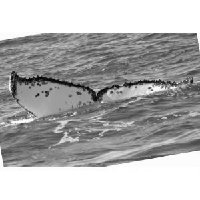

In [100]:
array_to_img(X_test[2256])

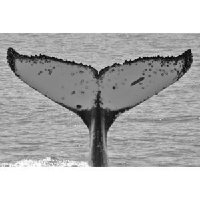

In [101]:
array_to_img(X_test[2257])

In [93]:
y_test[2255:2264]

array(['w_fc94e17', 'w_d287825', 'w_d287825', 'w_d287825', 'w_0cbf1b3',
       'w_0cbf1b3', 'w_0cbf1b3', 'w_0cbf1b3', 'w_0cbf1b3'], dtype='<U9')

In [102]:
network.save_weights('HBWhale_Model_Weights.h5')

NameError: name 'newtork' is not defined